In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import os

In [2]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

root = os.path.join(onedrive_path, 'CODES', 'samples', 'cifar10_data')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])#<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


cifar10_train = datasets.CIFAR10(root=root, download=True, train=True, transform=transform)
cifar10_test = datasets.CIFAR10(root=root, download=True, train=False, transform=transform)

train_dataloader = DataLoader(cifar10_train, batch_size=100, shuffle=True)
test_dataloader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

Using device: cpu


In [4]:
def split_into_kernels(image, kernel_size):
    """
    画像を kernel_size x kernel_size のパッチに分割
    返り値のサイズ: (b, n_patches, c, kernel_size, kernel_size)
    """
    b, c, h, w = image.shape
    assert (h % kernel_size == 0) and (w % kernel_size == 0), "Image size must be divisible by kernel size"
    patches = image.unfold(2, kernel_size, kernel_size).unfold(3, kernel_size, kernel_size)
    patches = patches.contiguous().view(b, c, -1, kernel_size, kernel_size)
    patches = patches.permute(0, 2, 1, 3, 4)
    return patches

In [ ]:
class Encoder(nn.Module):
    def __init__(self, kernel_size, leverage, channels):
        super(Encoder, self).__init__()
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = (kernel_size ** 2) * channels
        self.output_dim = int(kernel_in / leverage)
        phase = torch.rand(self.output_dim, kernel_in) * 2 * np.pi - np.pi
        modulus = torch.ones(self.output_dim, kernel_in)
        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

    def forward(self, x):
        b, n_patches, c, kh, kw = x.shape
        #alpha = torch.rand(1).item() * 0.5 + 0.5
        alpha = torch.rand(self.kernel_in).to(x.device) * 0.5 + 0.5
        x = x.reshape(b * n_patches, c * kh * kw)
        x = torch.exp(1j * alpha * x) 
        x = x.T 
        x = torch.matmul(self.B, x)
        x = x.T
        x = torch.abs(x) ** 2  
        return x , n_patches

In [6]:
class MLP(nn.Module):#３層
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        
        hidden_dim1 = input_dim // 2
        hidden_dim2 = hidden_dim1 // 2
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, 10)
        self.func = nn.ReLU()

    def forward(self, x):
        x = self.func(self.fc1(x))  # 1層目
        x = self.func(self.fc2(x))  # 2層目
        x = self.fc3(x)             # 出力層
        return x

In [ ]:
class EncoderClassifier(nn.Module):
    def __init__(self, img_size, channels, kernel_size, leverage):
        super(EncoderClassifier, self).__init__()
        self.img_size = img_size
        self.channels = channels
        self.kernel_size = kernel_size
        self.leverage = leverage

        kernel_in = channels * kernel_size ** 2
        feat_dim = int(kernel_in / leverage)
        n_patches = (img_size // kernel_size) * (img_size // kernel_size)

        self.encoder = Encoder(kernel_size, leverage, channels)
        self.bn = nn.BatchNorm1d(feat_dim*n_patches)  # CNNのためにBatchNorm2dに変更
        self.classifier = MLP(feat_dim*n_patches)  # CNNの入力チャネル数をfeat_dimに変更

    def forward(self, x):
        #print("x",x)
        b = x.size(0)
        x = x.view(b, self.channels, self.img_size, self.img_size)
        x = split_into_kernels(x, self.kernel_size)
        x, n_patches = self.encoder(x)
        #print("x",x)
        x = x.reshape(b, -1)
        x = self.bn(x)#<<<<<<<<<<<<<<<<<<<<<<<<
        x = self.classifier(x)
        
        return x

1/5th Time Epoch: 20/20

Test Accuracy: 36.12%
loss_train: 1.7755,loss_test: 1.7656
LOSS:1.7656
ProcessingTime: 125.25907111167908


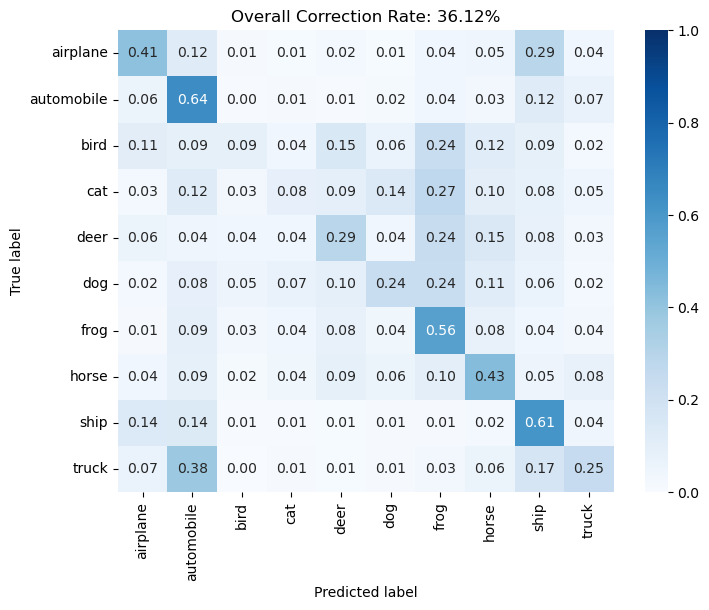

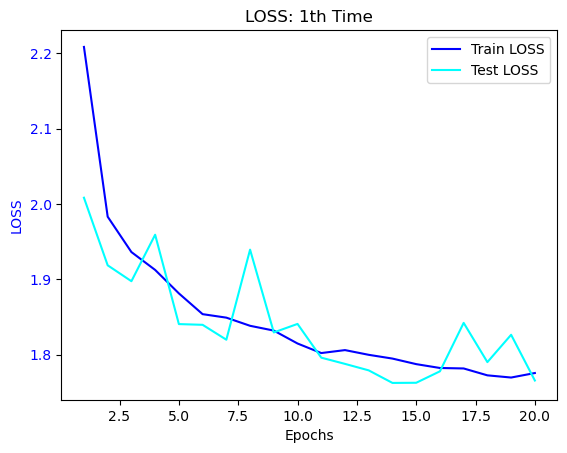

2/5th Time Epoch: 20/20

Test Accuracy: 33.10%
loss_train: 1.8285,loss_test: 1.8293
LOSS:1.8293
ProcessingTime: 118.55640196800232


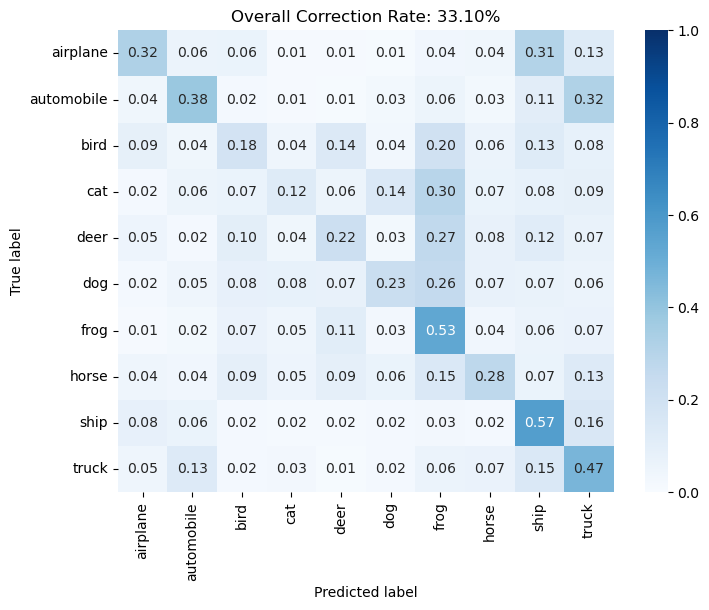

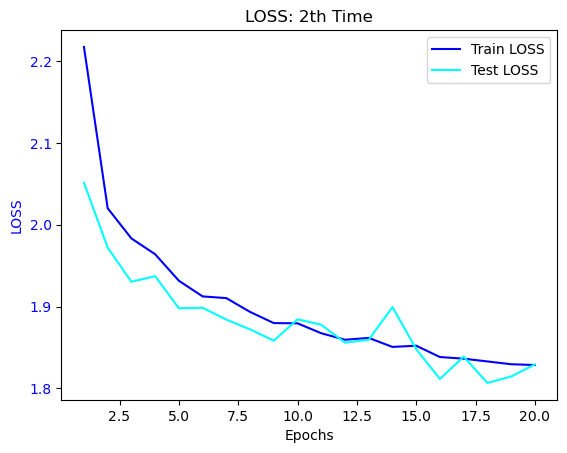

3/5th Time Epoch: 20/20

Test Accuracy: 35.45%
loss_train: 1.7949,loss_test: 1.7946
LOSS:1.7946
ProcessingTime: 119.03030490875244


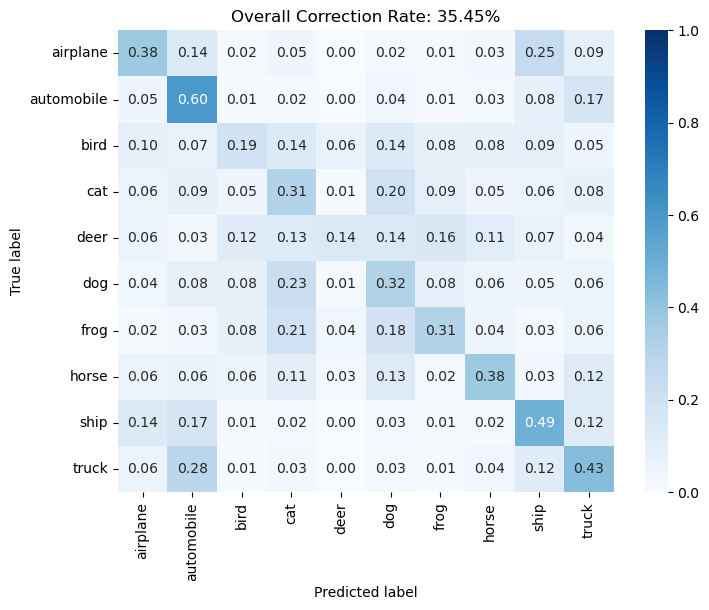

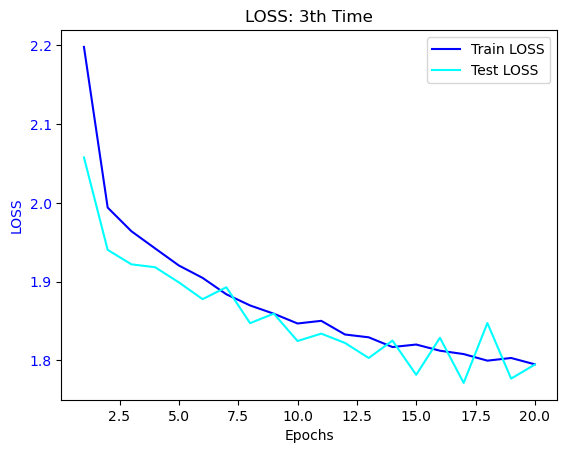

4/5th Time Epoch: 20/20

Test Accuracy: 33.99%
loss_train: 1.7866,loss_test: 1.7978
LOSS:1.7978
ProcessingTime: 119.15021228790283


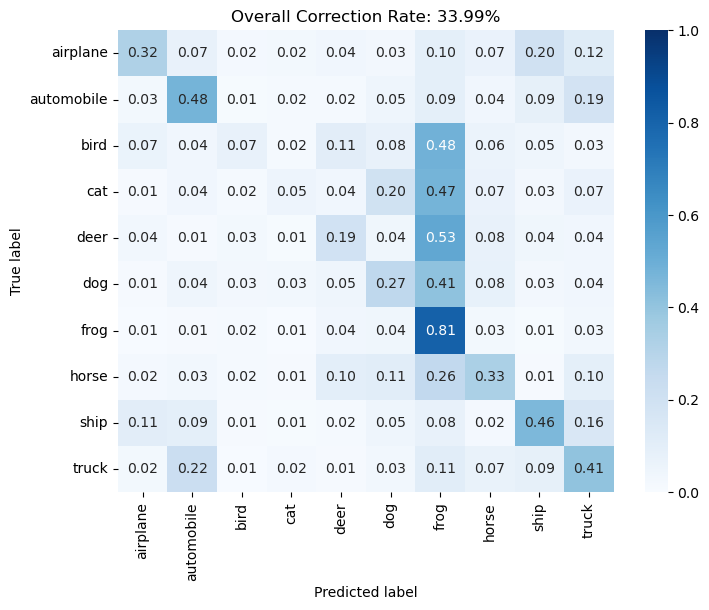

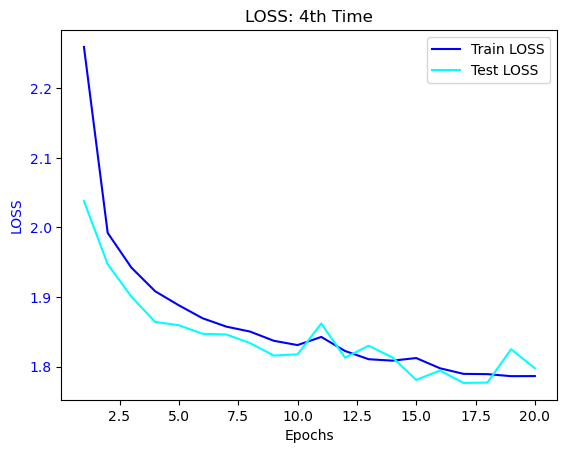

5/5th Time Epoch: 20/20

Test Accuracy: 31.84%
loss_train: 1.8502,loss_test: 1.8714
LOSS:1.8714
ProcessingTime: 121.26693797111511


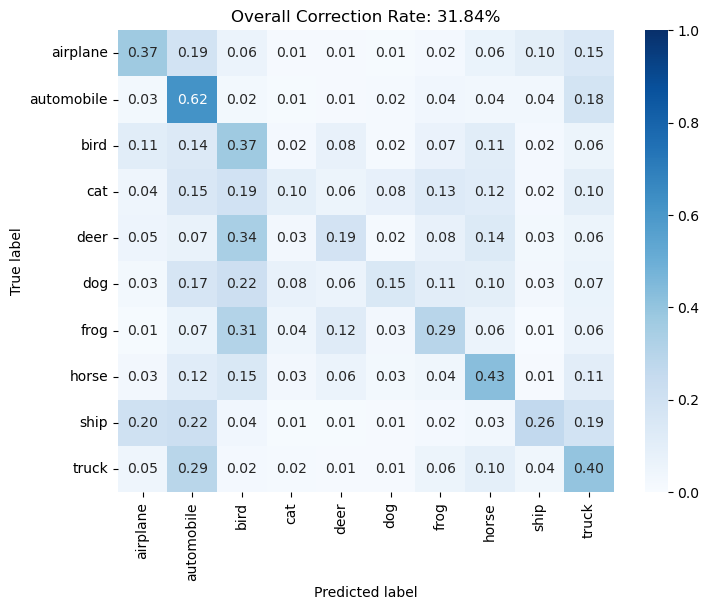

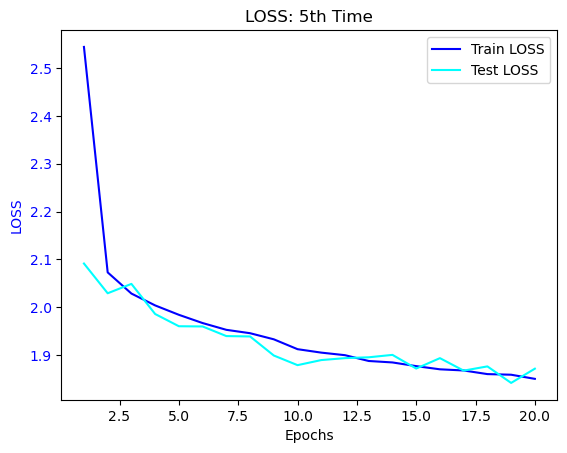

In [8]:
channels = 3
img_size = 32
leverage = 8
kernel_size = 4

max_epochs = 20##10

num_try = 5##5

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 

    model = EncoderClassifier(img_size,channels, kernel_size, leverage).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

            
    for epoch in range(max_epochs):

        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs)) 
        sys.stderr.flush()

        loss_train = 0
        loss_test = 0

        start_time1 = time.time()
        for (x,t) in train_dataloader:
                    
            x, t = x.to(device), t.to(device)
            y = model(x).to(device)
            loss = criterion(y, t) 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

       
        loss_train_avg = loss_train / len(train_dataloader)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        model.eval()
        with torch.no_grad():
            all_preds = []
            all_labels = []
            correct = 0
            total = 0
            for x, t in test_dataloader:
                x, t = x.to(device), t.to(device)
                y = model(x).to(device)
                _, predicted = torch.max(y, 1)
                loss = criterion(y,t)
                loss_test += loss.item()        
                total += t.size(0)
                correct += (predicted == t).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(t.cpu().numpy()) 
        
        #print(f"Test Accuracy: {100 * correct / total:.2f}%")
        loss_test_avg = loss_test / len(test_dataloader)

        loss_train_.append(loss_train_avg)
        loss_test_.append(loss_test_avg)
        #if epoch == max_epochs-1:
    All_loss_test.append(loss_test_)
    All_pro_time.append(sum(pro_time_)) 

    cm = confusion_matrix(all_labels, all_preds)
    cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

    Last_loss_test = loss_test_[-1]
    All_last_loss.append(Last_loss_test)
    Test_acc = 100 * correct / total
    All_test_acc.append(Test_acc)
    print(f"Test Accuracy: {Test_acc:.2f}%")
    print(f"loss_train: {loss_train_avg:.4f},loss_test: {loss_test_avg:.4f}")
    print(f"LOSS:{Last_loss_test:.4f}")
    print('ProcessingTime:',sum(pro_time_))
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names,vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(f"Overall Correction Rate: {Test_acc:.2f}%")
    plt.show()

    fig, ax1 = plt.subplots()
    ax1.plot(range(1,len(loss_train_)+1), loss_train_, label="Train LOSS", color = 'blue')
    ax1.plot(range(1,len(loss_test_)+1), loss_test_, label="Test LOSS", color = 'cyan')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color = 'blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend()

    title = 'LOSS: %dth Time'%(num_times+1) #
    plt.title(title)
    plt.show()


In [9]:
import csv
ACC_mean = np.mean(All_test_acc)
ACC_best = np.max(All_test_acc)
ACC_bestID = np.argmax(All_test_acc)+1
ACC_worst = np.min(All_test_acc)
ACC_worstID = np.argmin(All_test_acc)+1

LOSS_mean = np.mean(All_last_loss)
LOSS_best = np.min(All_last_loss)
LOSS_bestID = np.argmin(All_last_loss)+1
LOSS_worst = np.max(All_last_loss)
LOSS_worstID = np.argmax(All_last_loss)+1

data = {
        "": ["ACC", "LOSS"],
    "Average": [ACC_mean, LOSS_mean],
    "Best ID": [ACC_bestID, LOSS_bestID],
    "Best": [ACC_best, LOSS_best],
    "Worst ID": [ACC_worstID, LOSS_worstID],
    "Worst": [ACC_worst, LOSS_worst],
}

df = pd.DataFrame(data)

print(df)


           Average  Best ID       Best  Worst ID      Worst
0   ACC  34.100000        1  36.120000         5  31.840000
1  LOSS   1.811733        1   1.765583         5   1.871418


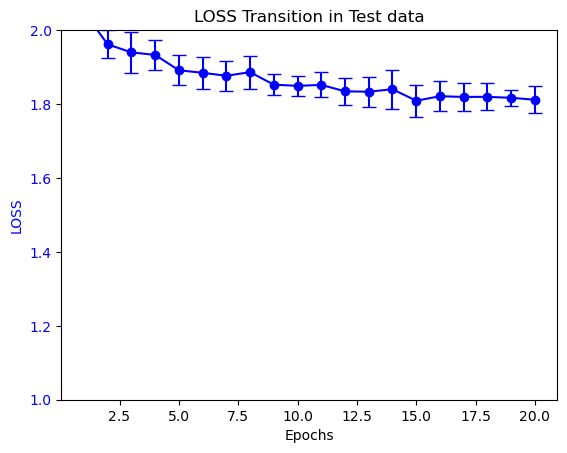

In [10]:
epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

# 各エポックごとに平均と標準偏差を計算
mean_loss = np.mean(All_loss_test, axis=0)
std_loss = np.std(All_loss_test, axis=0)

# グラフの描画
fig, ax1 = plt.subplots()

# 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
ax1.errorbar(
    x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
    fmt='-o', color='blue', ecolor='blue', capsize=5, 
)

# 軸ラベルやタイトルの設定
ax1.set_xlabel('Epochs')
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.title('LOSS Transition in Test data')
plt.ylim(1.0,2.0)
plt.show()

In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_Classifer', 'data','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'cifar10_CNN_PM_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_loss_test)

/Users/konishi/OneDrive/CODES/konishi_Classifer/data/texts
